# Volatility Models & Volatility Surface 

In [155]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import math
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.interpolate import interp1d
from scipy.optimize import minimize
import warnings
import ipywidgets as widgets
%matplotlib inline

# SVI

The first model we are interested in is the **Stochastic Volatility Implied** model, also called SVI. 
Developped by Gatheral, it proposes the following parametrization of the total variance w, with 5 parameters : 

$\
w(k) = a + b \cdot \rho \cdot (k - m) + b \cdot \sqrt{(k - m)^2 + \sigma^2} 
\$

$\
w(k) = \sigma_{BS}^2 \cdot t
\$

### Parameters:
The five parameters $\ a, b, \rho, m, \sigma \$ are time-dependent, with the following constraints:

- $\ a \in \mathbb{R} \$
  
- $\ b \in \mathbb{R}^+ \$ 
  
- $\ |\rho| < 1 \$
  
- $\ m \in \mathbb{R} \$
  
- $\ \sigma > 0 \$

- **Log-moneyness**: $\ k = \ln(K / S) \$

In [159]:
def VolSVI(S0, K, T, a, b, rho, sigma, m):
    k = np.log(K / S0)
    return np.sqrt((a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))) / T)

In [161]:
widgets.interact(
a = (-0.2, 0.2, 0.01), b = (0, 2., 0.01), rho = (-0.9, 0.9, 0.1), m = (-5., 5., 0.1), sigma = (0.1, 2., 0.1))

def plot(a = 0, b = .2, rho = .5, m = 1., sigma = 0.5):
    S0 = 100
    T = 1.
    Strikes = range(50, 200)
    fig, axs = plt.subplots(1,figsize = (30, 15))
    axs.plot(Strikes,[VolSVI(S0, K, T, a, b, rho, sigma, m) for K in Strikes], label = "Implied Volatility", linewidth = 7)
    axs.set_title('Implied Volatility with SVI Parameterization', fontsize = 30,)
    axs.set_xlabel('Strike Price', fontsize = 30)
    axs.set_ylabel('Implied Volatility', fontsize = 30)
    axs.tick_params(axis='x', labelsize = 20)
    axs.tick_params(axis='y', labelsize = 20)
    axs.legend(fontsize=30)
    plt.show()

## SVI Calibration to Market Prices

#### Black‑Scholes Price

In [165]:
def CallPrice(S, sigma, K, T, r):
    d1 = (math.log(S / K) + (r + .5 * sigma**2) * T) / (sigma * T**.5)
    d2 = d1 - sigma * T**0.5
    n1 = norm.cdf(d1)
    n2 = norm.cdf(d2)
    DF = math.exp(-r * T)
    price=S * n1 - K * DF * n2
    return price

#### Market Prices

In [168]:
r = 0.05 #RiskFree Interest Rate
S0 = 100 #Asset Price
IV = [.36, .28, .26, .245, .24, .242, 0.248] #BlackScholes Implied Vol
K = [90, 95, 97.5, 100, 102.5, 105, 110] #Strike Prices
T = [.25] * 7 #Maturity
Price = [CallPrice(S0, IV[i], K[i], T[i], r) for i in range(len(T))]

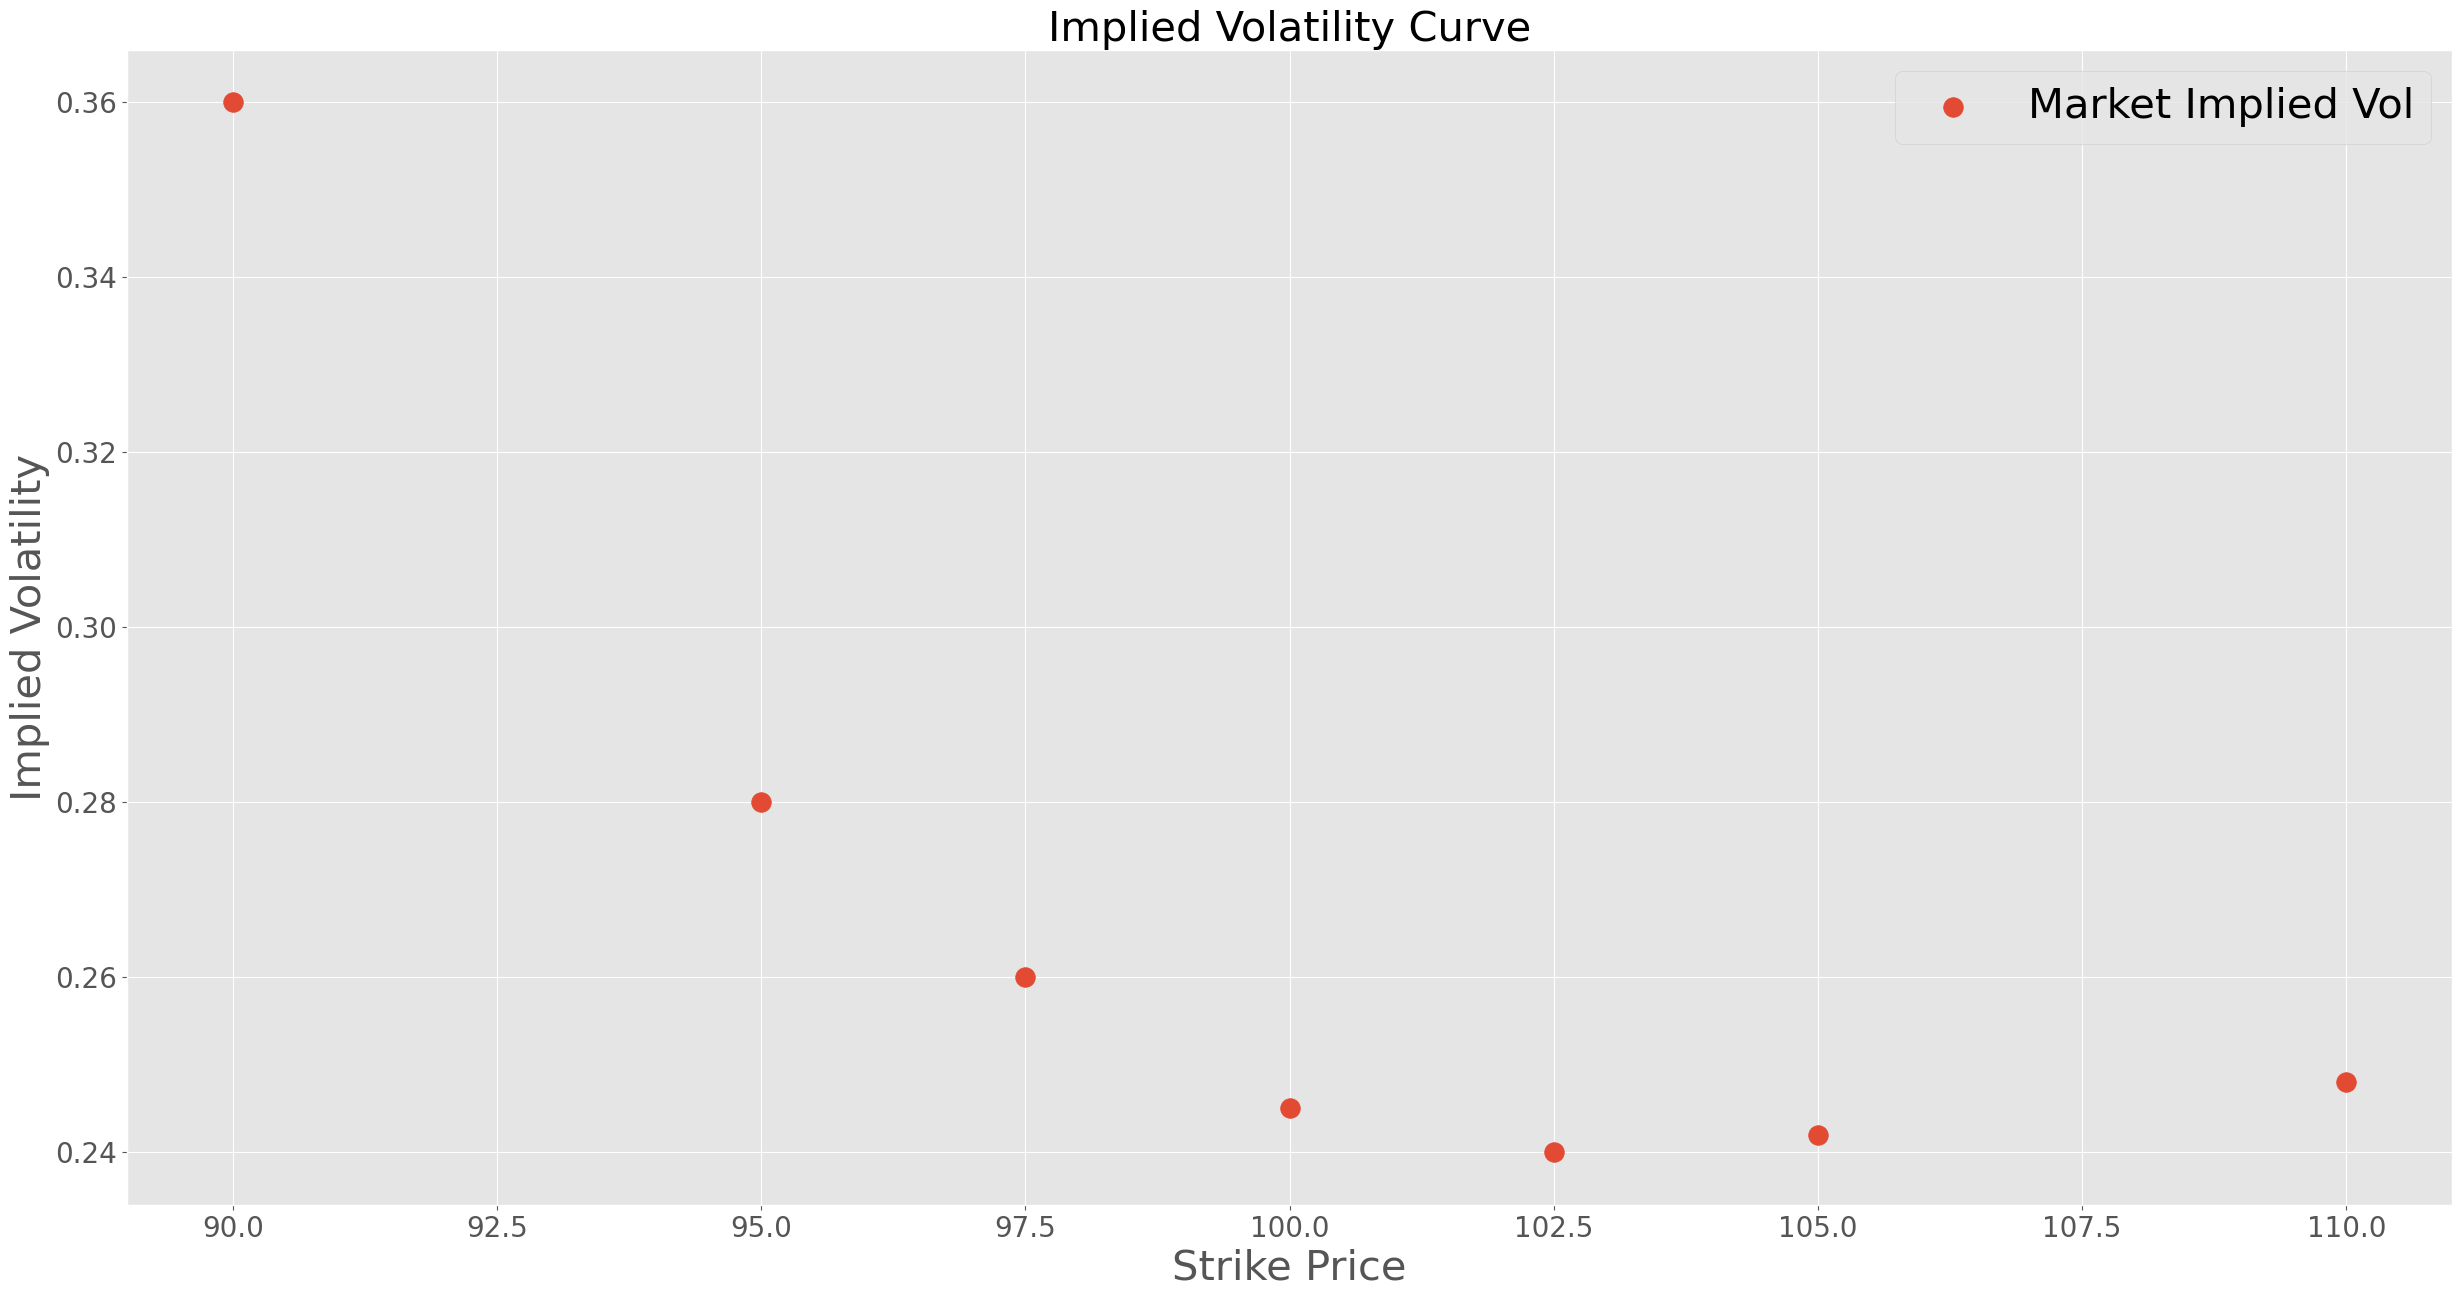

In [170]:
fig, axs = plt.subplots(1,figsize = (30, 15))
axs.scatter(K, IV, label="Market Implied Vol", s = 200)
axs.set_title('Implied Volatility Curve', fontsize = 30,)
axs.set_xlabel('Strike Price', fontsize = 30)
axs.set_ylabel('Implied Volatility', fontsize = 30)
axs.tick_params(axis='x', labelsize = 20)
axs.tick_params(axis='y', labelsize = 20)
axs.legend(fontsize=30)
plt.show();

## Mean‑Squared Error Minimisation between Market and Model Prices

We now want to find the true values of our parameters, and we will use a minimization to find their values

In [172]:
#Mean Squared Error
#params = (a, b, rho, sigma, m)
def MSE_Price_SVI(params):
    MSE_Price = 0
    for i in range(len(T)):
        MSE_Price = MSE_Price + (CallPrice(S0, VolSVI(S0, K[i], T[i], *params), K[i], T[i], r) - Price[i])**2
        
    return MSE_Price / len(T)
    
def MSE_IV_SVI(params):
    MSE_IV = 0
    for i in range(len(T)):
        SVI_IV = VolSVI(S0, K[i], T[i], *params)
        MSE_IV = MSE_IV + (SVI_IV - IV[i])**2
    return MSE_IV / len(T)
   
#Constraints
cons=(
    {'type': 'ineq', 'fun': lambda x: x[1] - 0.0}, #b > 0
    {'type': 'ineq', 'fun': lambda x: .99999 - x[2]}, #rho < 1
    {'type': 'ineq', 'fun': lambda x: x[2] + .99999}, #rho > 1
    {'type': 'ineq', 'fun': lambda x: x[3] - 0.00001}, #sigma > 0
    #min w(k) > 0
    {'type': 'ineq', 'fun': lambda x: x[0] + x[1] * x[3] *(1 - x[2]**2)**.5 - 0.00001},
)

In [173]:
warnings.filterwarnings('ignore')
params = [20., 5., .5, .5, 0.] #initial params ,(a, b, rho, sigma, m)
result = minimize(MSE_Price_SVI, params, constraints = cons, method = 'SLSQP',tol=1e-12 )
new_params = result['x']

In [174]:
#params = (a, b, rho, sigma, m)
print("Parameters: " + str(new_params))
print("MSE: " + str(MSE_Price_SVI(new_params)))

Parameters: [-0.09186706  0.64024227 -0.65815805  0.21980832 -0.15383895]
MSE: 0.002863721776345134


We can now plot the Volatility curve we have generated

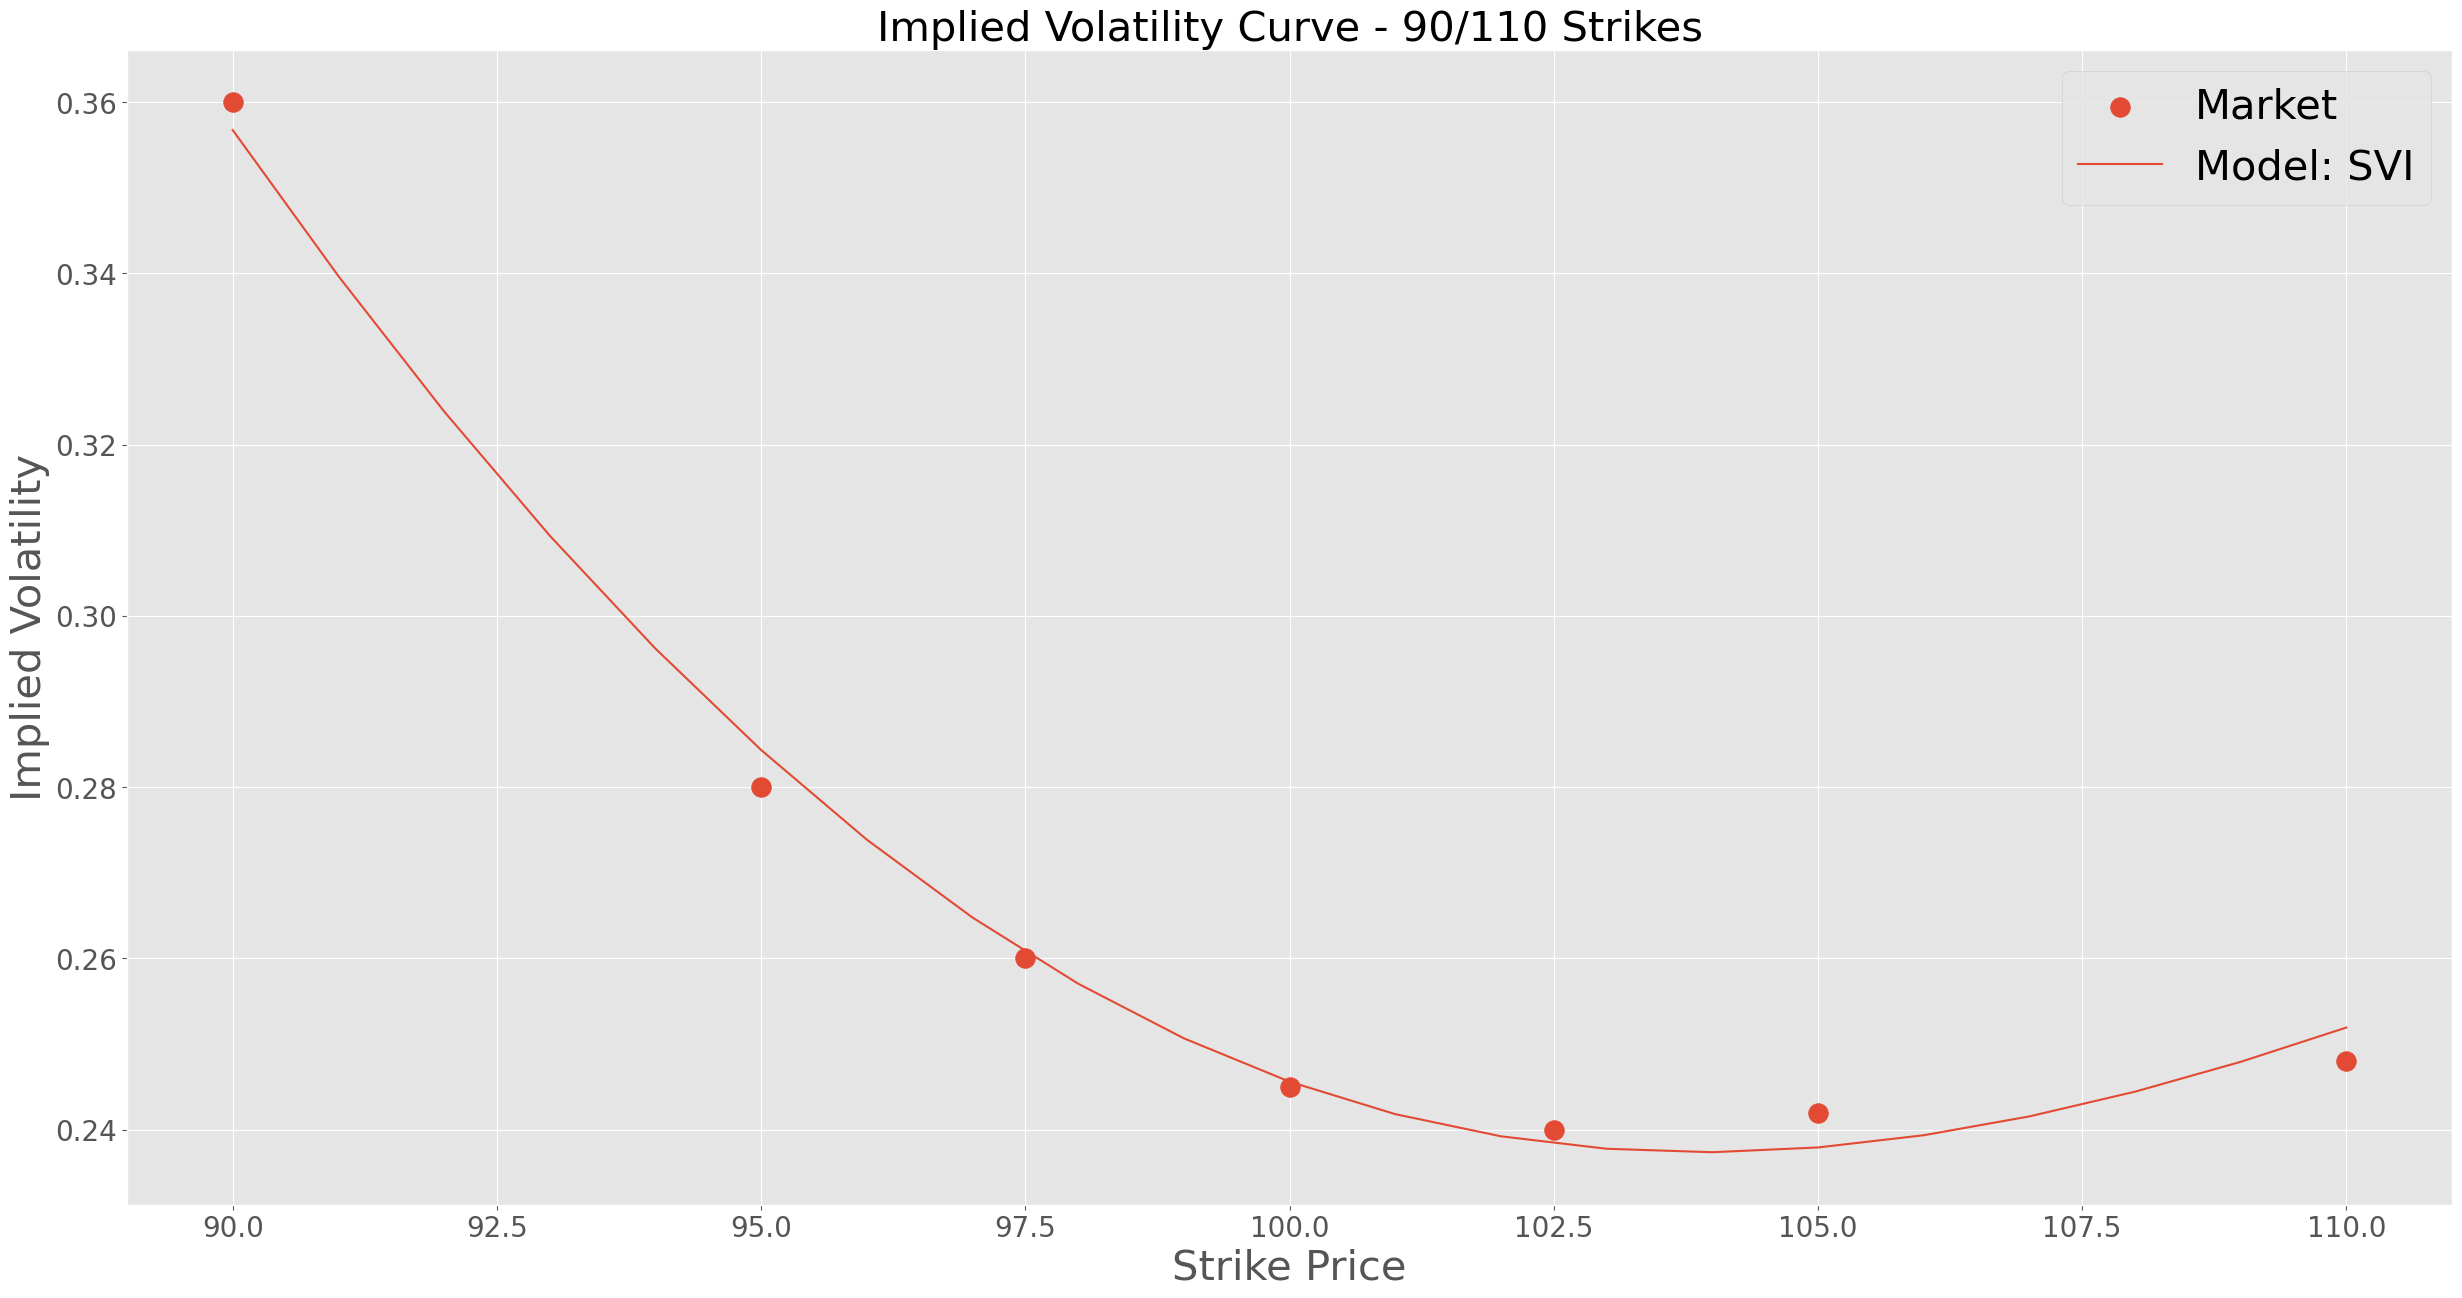

In [176]:
S0 = 100
r = 0.05
T_ = 0.25
Kbis = range(90, 111)
SVI_IV = [VolSVI(S0, Kbis[i], T_, *new_params) for i in range(len(Kbis))]
fig, axs = plt.subplots(1,figsize = (30, 15))
axs.scatter(K, IV, label="Market", s = 200)
axs.plot(Kbis, SVI_IV, label="Model: SVI")
axs.set_title('Implied Volatility Curve - 90/110 Strikes', fontsize = 30,)
axs.set_xlabel('Strike Price', fontsize = 30)
axs.set_ylabel('Implied Volatility', fontsize = 30)
axs.tick_params(axis='x', labelsize = 20)
axs.tick_params(axis='y', labelsize = 20)
axs.legend(fontsize=30)
plt.show();

Let's plot the whole curve and not only focus on 90-110 strikes

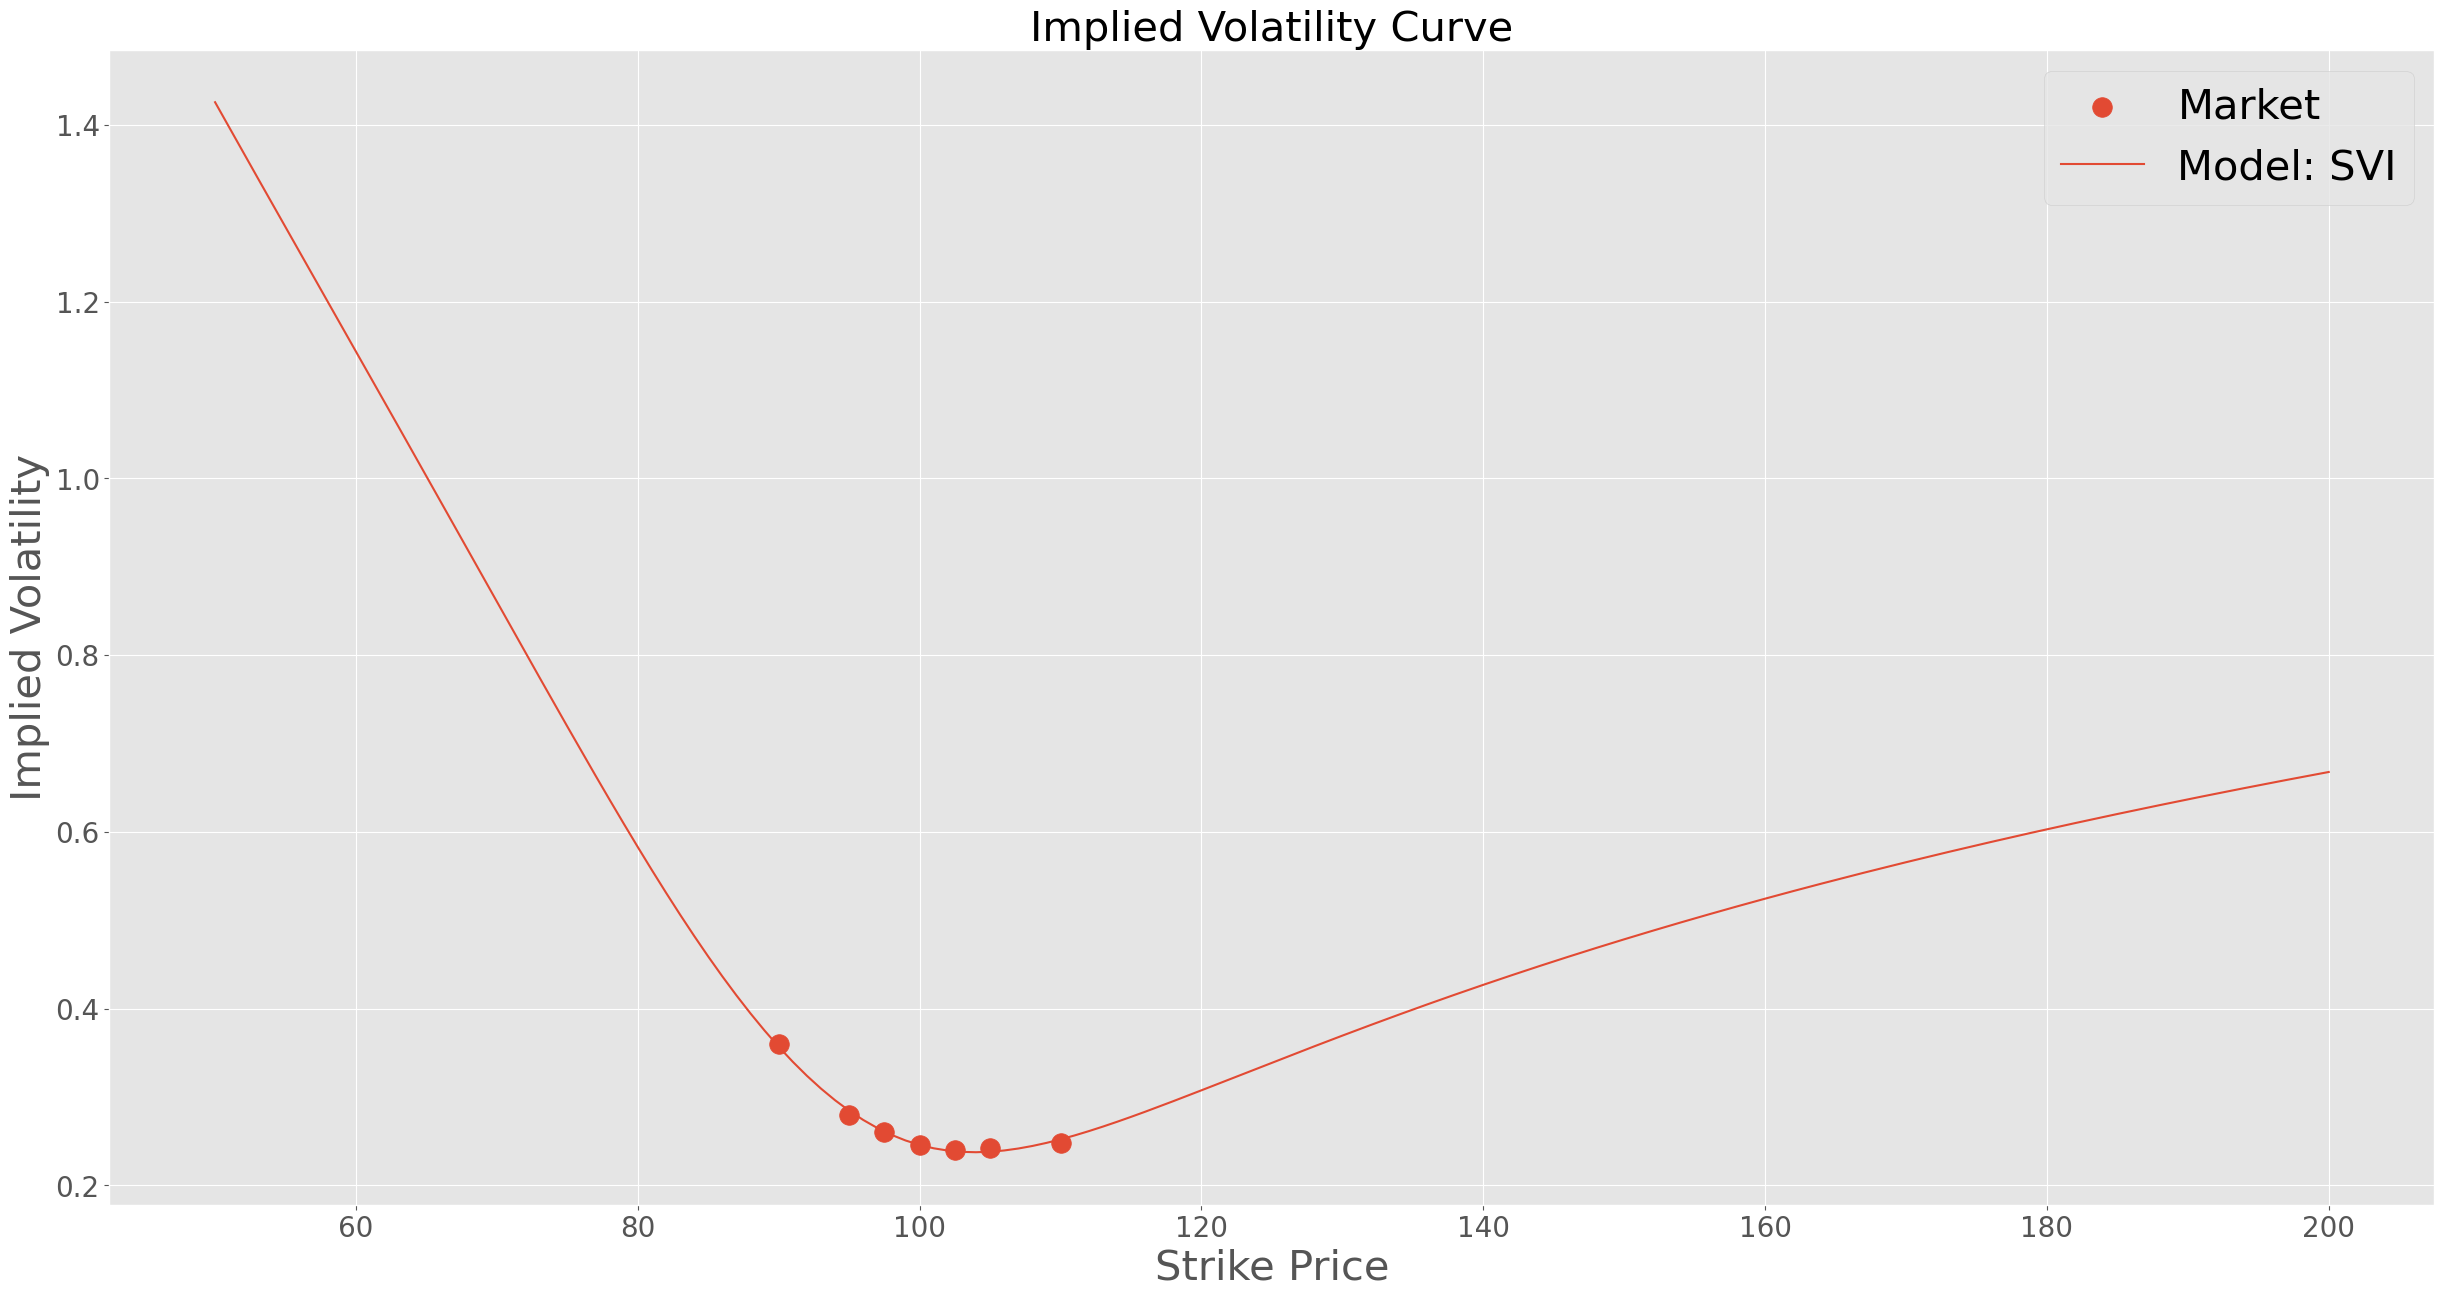

In [178]:
S0 = 100
r = 0.05
T_ = 0.25
Kbis = range(50, 201)
SVI_IV = [VolSVI(S0, Kbis[i], T_, *new_params) for i in range(len(Kbis))]
fig, axs = plt.subplots(1,figsize = (30, 15))
axs.scatter(K, IV, label="Market", s = 200)
axs.plot(Kbis, SVI_IV, label="Model: SVI")
axs.set_title('Implied Volatility Curve', fontsize = 30,)
axs.set_xlabel('Strike Price', fontsize = 30)
axs.set_ylabel('Implied Volatility', fontsize = 30)
axs.tick_params(axis='x', labelsize = 20)
axs.tick_params(axis='y', labelsize = 20)
axs.legend(fontsize=30)
plt.show()

# SSVI

The second model studied is SSVI, which is an "enhanced" version of the SVI model. It is used to build Non-Arbitrage volatility surface.
Recall the following conditions of static arbitrage : 

## Static Arbitrage

A volatility surface is free of static arbitrage if and only if:

- **Each time slice is free of butterfly arbitrage**  
  $\
  \frac{\partial^2 C}{\partial K^2} \geq 0
  $
  

- **It is free of calendar spread arbitrage**  
  $\
  \frac{\partial C}{\partial t} \geq 0
  $

## Volatility Surface with SSVI Parameterization

The implied variance $\ \sigma^2(k, t) \$,  where **k** is the log-moneyness and **t** is the time to maturity, is given by:

$$
\
w(k, t) = \sigma^2(k, t) = \frac{\theta(t)}{2} \left( 1 + \rho \phi(t) k + \sqrt{(\phi(t)k + \rho)^2 + (1-\rho^2)} \right),
\
$$

where:

- $\ w(k, t) $ : Implied total variance as a function of **k** and **t**.
  
- $\ \theta(t) $ : Total variance at-the-money (ATM) at time \( t \).
  
- $\ \rho $ : Correlation parameter between the underlying asset and volatility.
  
- $\ \phi(t) $ : A function that controls the slope of the skew and is typically positive.
  
- $\ k $ : Log-moneyness, defined as $\ k = \ln(K / F) $\, where **K** is the strike price and **F** is the forward price.

### Notes:
- The term $\ \rho \phi(t)k $ determines the skew of the implied volatility.
- The square root term ensures convexity and controls the behaviour of the smile.

We choose to define \$ \theta(t) $ , which is responsible for the ATM modelisation, with the following function with 3 parameters :

$\
\theta_t = \left( \frac{1 - \exp(-\kappa \cdot t)}{\kappa \cdot t} \cdot \left( \nu_0 - \nu_\infty \right) + \nu_\infty \right) \cdot t 
$

- $\ \nu_0 $: controls the very short-term ATM volatility level  
- $\ \nu_\infty $: controls the long-term ATM volatility level  
- $\ \kappa $: controls the speed of convergence to long-term volatility

In [188]:
def theta(t, nu_0, nu_inf, kappa):
    return ((nu_0 - nu_inf) * (1 - np.exp( kappa * t)) / (kappa * t) + nu_inf) * t

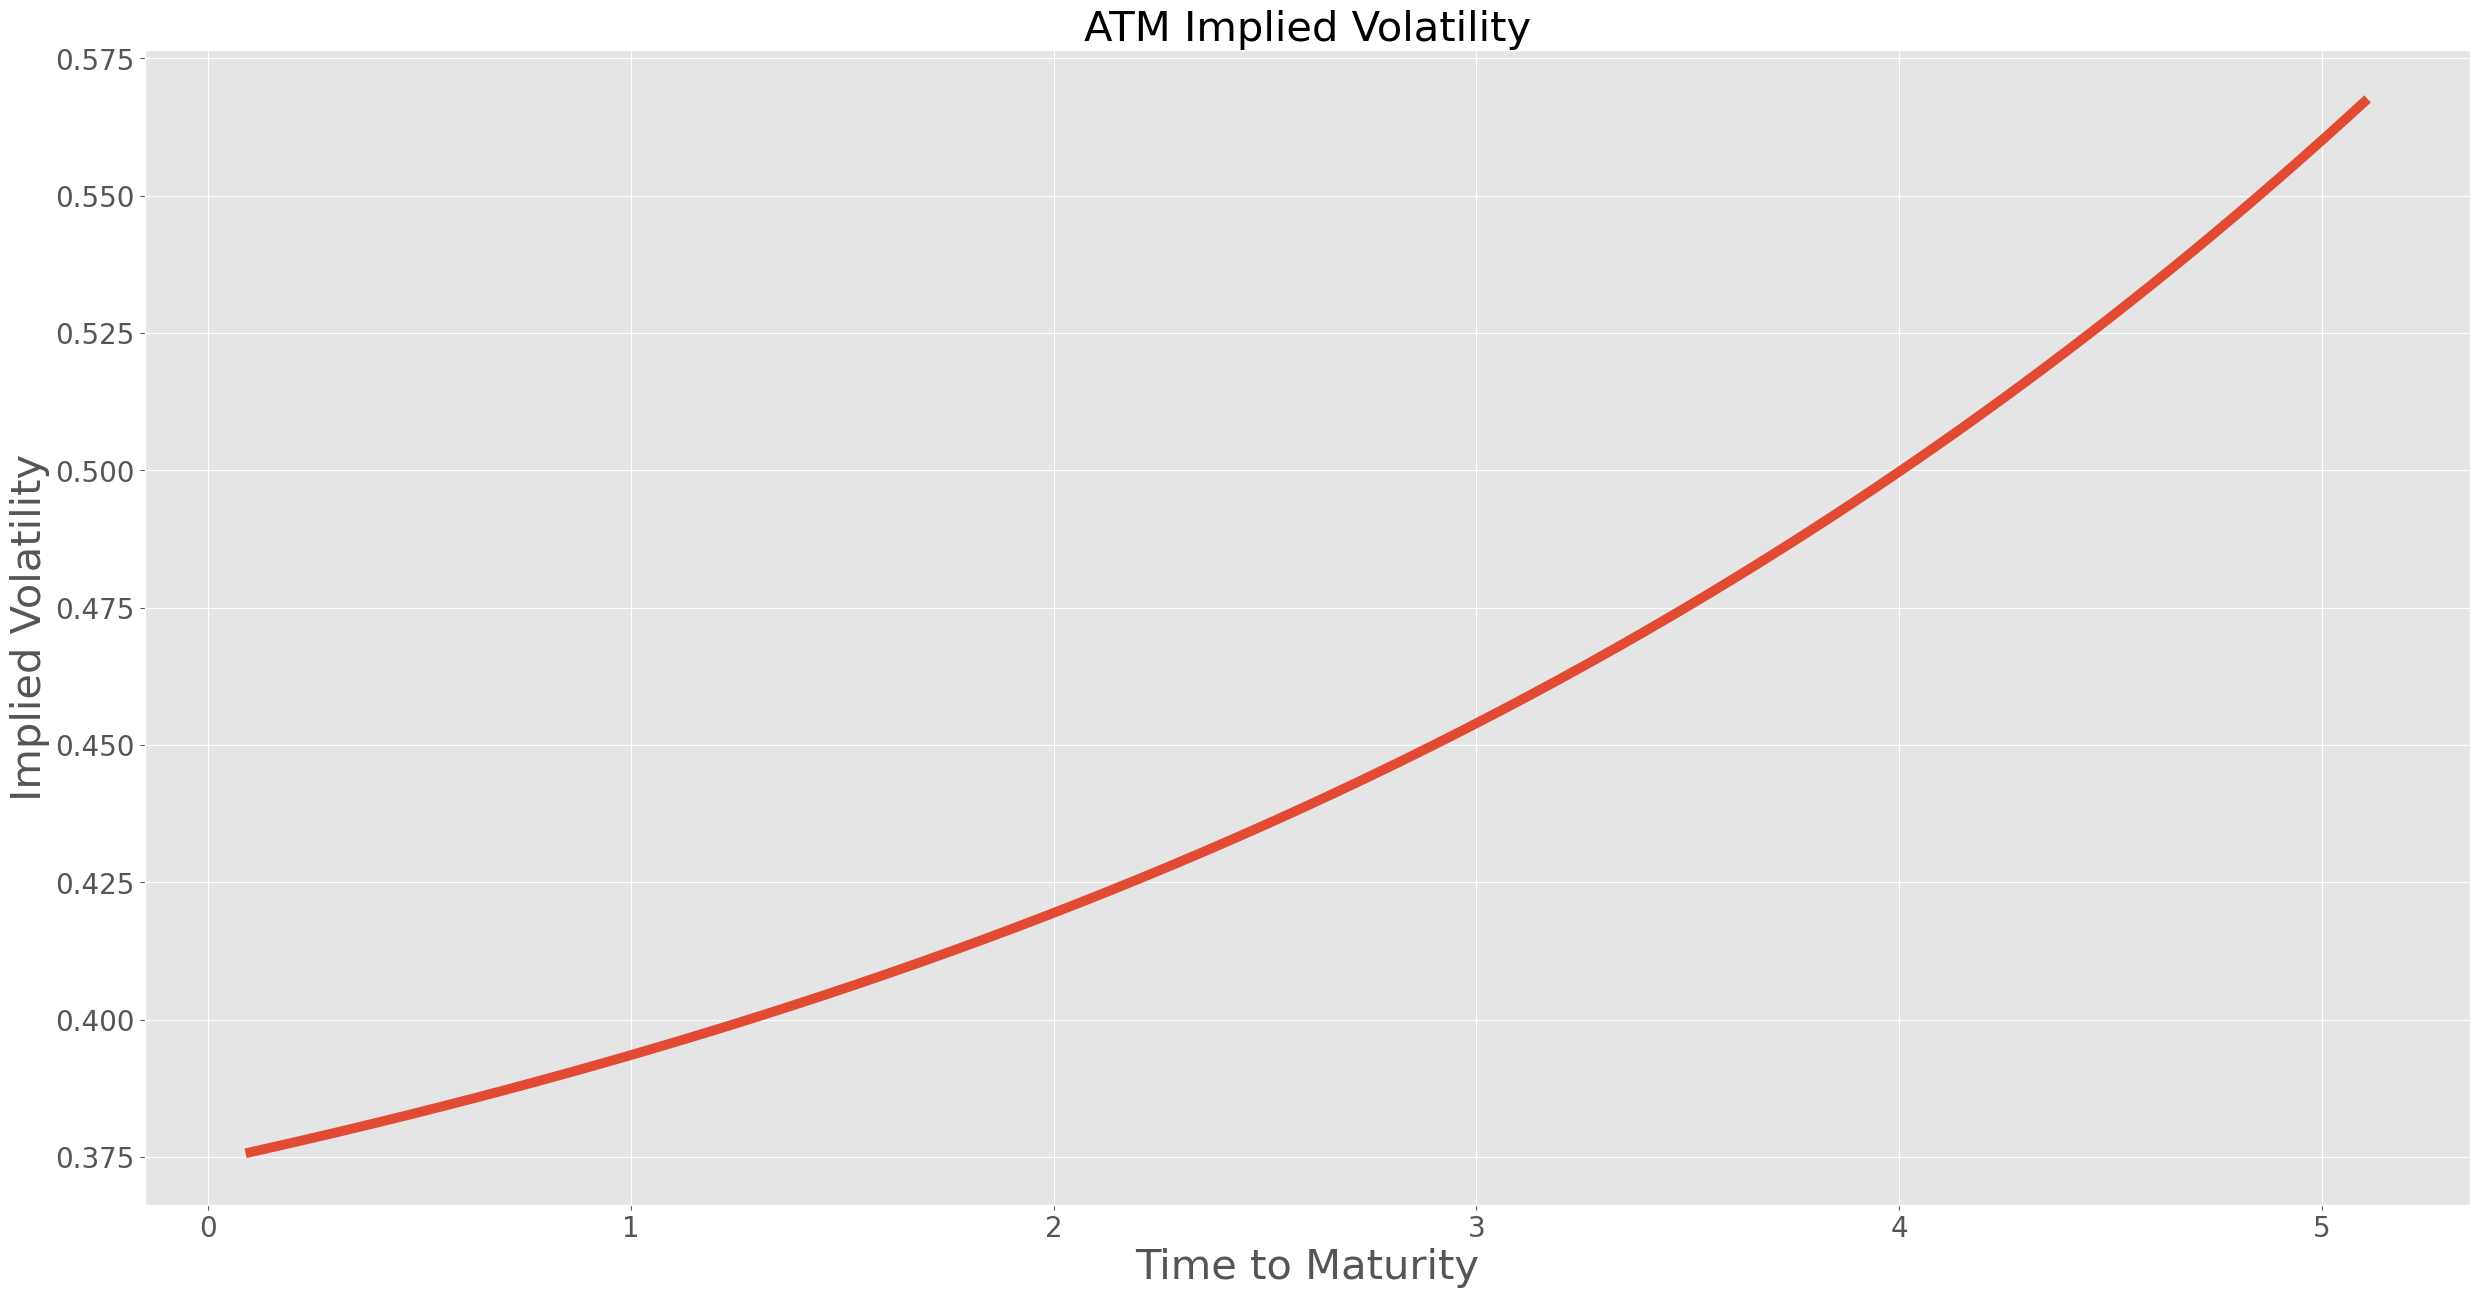

In [189]:
t_ = np.linspace(0.1, 5.1, 200)
nu_0 = 0.2**2
nu_inf = 0.3**2
kappa = 0.5
IV_ATM = [(theta(t, nu_0, nu_inf, kappa)/t)**.5 for t in t_]
fig, axs = plt.subplots(1,figsize = (30, 15))
axs.plot(t_, IV_ATM, linewidth = 7)
axs.set_title('ATM Implied Volatility', fontsize = 30,)
axs.set_xlabel('Time to Maturity', fontsize = 30)
axs.set_ylabel('Implied Volatility', fontsize = 30)
axs.tick_params(axis='x', labelsize = 20)
axs.tick_params(axis='y', labelsize = 20)
plt.show();

In [191]:
def phi(x, eta, lambda_):
    return eta * x**lambda_

In [193]:
def TotalVarSSVI(S0, K, t, nu_0, nu_inf, kappa, eta, lambda_, rho):
    k = np.log(K / S0)
    theta_t = theta(t, nu_0, nu_inf, kappa)
    phi_ = phi(theta_t, eta, lambda_)
    return theta_t / 2 * (1 + rho * phi_ * k + ((phi_ * k + rho)**2 + (1 - rho**2))**.5)

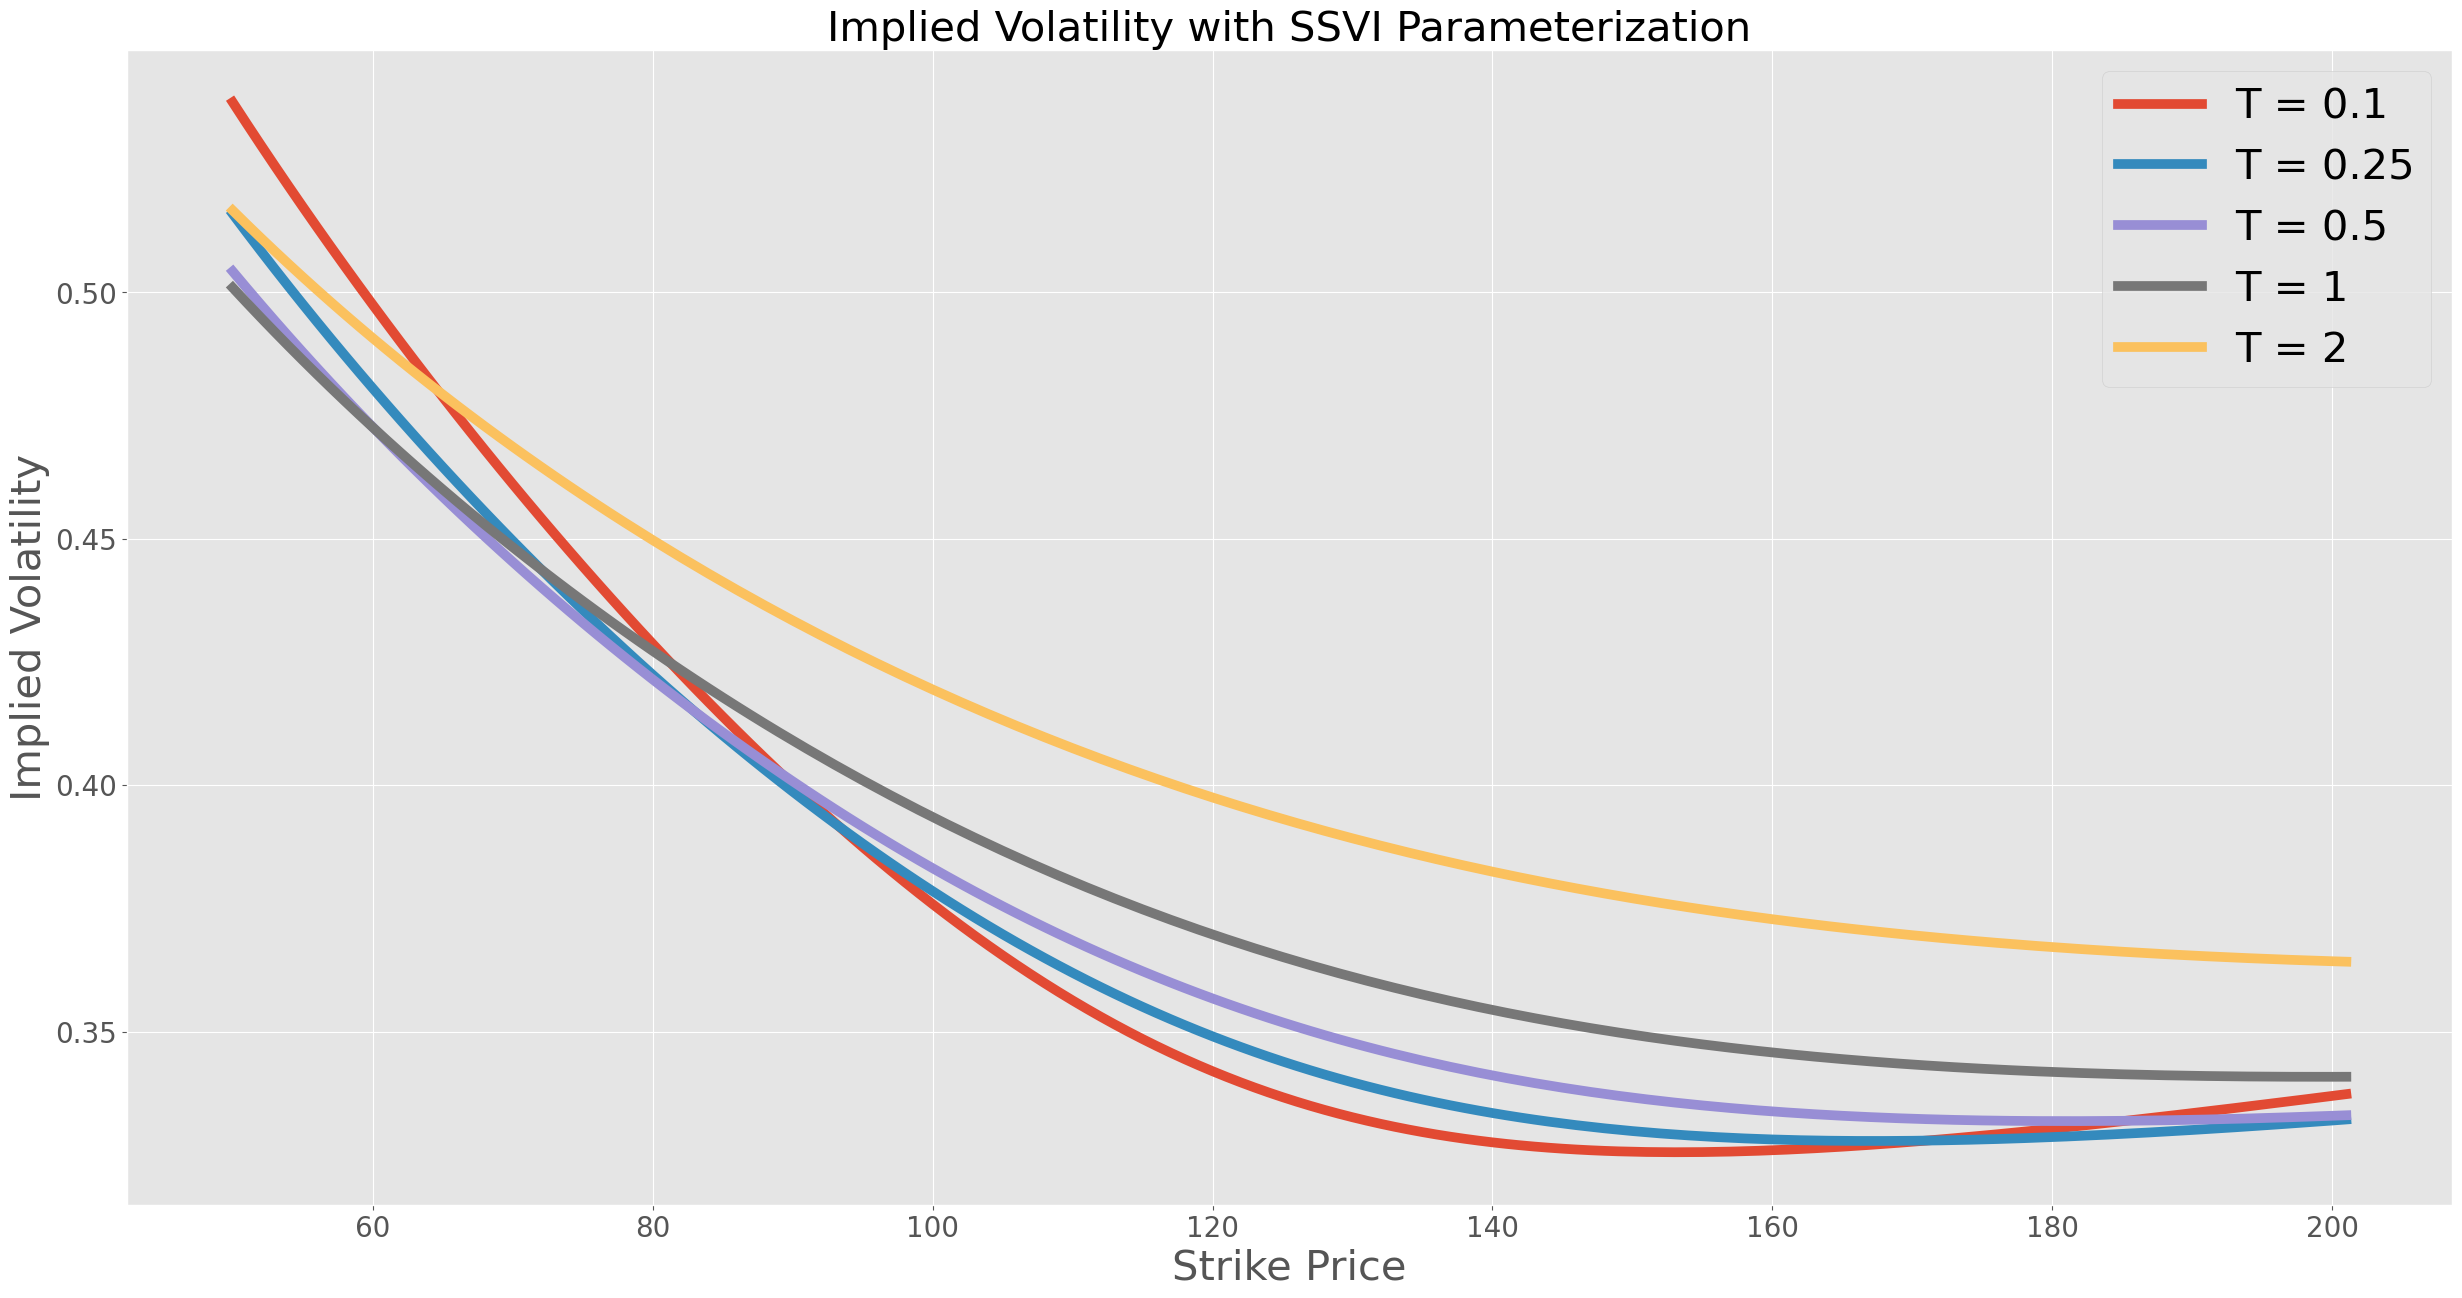

In [195]:
#Parameters
S0 = 100
Strikes = range(50, 202)
t = [0.1, 0.25, 0.5, 1, 2]
#ATM vol params
nu_0 = 0.2**2
nu_inf = 0.3**2
kappa = 0.5
#Other SSVI parameters
eta = 1.
lambda_ = -0.2
rho = -0.5
IV = [[(TotalVarSSVI(S0, K, t_, nu_0, nu_inf, kappa, eta, lambda_, rho) / t_)**0.5 \
    for K in Strikes] for t_ in t]

fig, axs = plt.subplots(1,figsize = (30, 15))
axs.plot(Strikes, IV[0], label = "T = 0.1", linewidth = 7)
axs.plot(Strikes, IV[1], label = "T = 0.25", linewidth = 7)
axs.plot(Strikes, IV[2], label = "T = 0.5", linewidth = 7)
axs.plot(Strikes, IV[3], label = "T = 1", linewidth = 7)
axs.plot(Strikes, IV[4], label = "T = 2", linewidth = 7)
axs.set_title('Implied Volatility with SSVI Parameterization', fontsize = 30,)
axs.set_xlabel('Strike Price', fontsize = 30)
axs.set_ylabel('Implied Volatility', fontsize = 30)
axs.tick_params(axis='x', labelsize = 20)
axs.tick_params(axis='y', labelsize = 20)
axs.legend(fontsize=30)
plt.show();

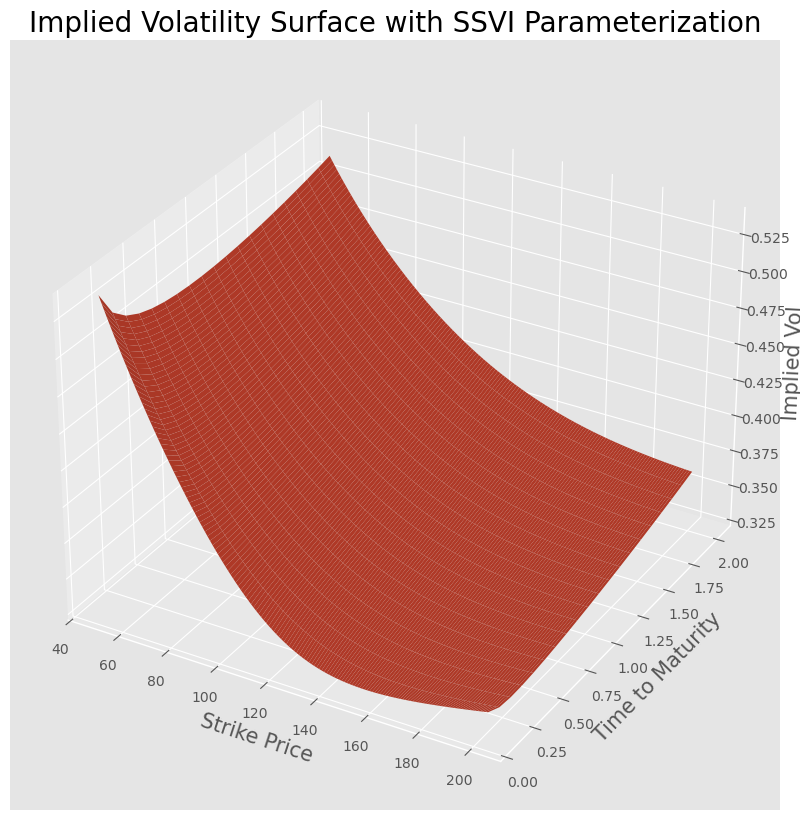

In [199]:
k = range(50, 202)
t = np.arange(0.1, 2.1, 0.1)
K, T = np.meshgrid(k, t)
def f(x, y):
    return (TotalVarSSVI(S0, x, y, nu_0, nu_inf, kappa, eta, lambda_, rho) / y)**0.5
IV = np.array([f(k_, t_) for kr, tr in zip(K, T) 
               for k_, t_ in zip(kr,tr) ]).reshape(len(K), len(K[0]))

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')
ax.plot_surface(K, T, IV, rstride=1, cstride=1);
ax.set_xlabel('Strike Price', fontsize = 15)
ax.set_ylabel('Time to Maturity', fontsize = 15)
ax.set_zlabel('Implied Vol', fontsize = 15)
ax.set_title('Implied Volatility Surface with SSVI Parameterization', fontsize = 20)
plt.show();

## SSVI Calibration to Market Prices

In [203]:
r = 0.05 #RiskFree Interest Rate
S0 = 100 #Asset Price
#BlackScholes Implied Volatility
IV = [.30, .27, .24, .25, .26, .28, .26, .245, .24, .242, \
.27, .26, .25, .245, .242, .265, .263, .26, .258, .257]
#Strike Prices
K = [95, 97.5, 100, 102.5, 105, 95, 97.5, 100, 102.5, 105, \
95, 97.5, 100, 102.5, 105, 95, 97.5, 100, 102.5, 105]
#Maturities
T = [0.1, 0.1, 0.1, 0.1, 0.1, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0]

MarketPrice = [CallPrice(S0, IV[i], K[i], T[i], r) for i in range(len(T))]

### Calibration ATM vol parameters
Calibration of nu_0, nu_inf and kappa from ATM market prices

In [206]:
Vol_ATM = [IV[i] for i in range(len(IV)) if K[i] == 100]
T_ATM = [T[i] for i in range(len(T)) if K[i] == 100]
Price_ATM = [MarketPrice[i] for i in range(len(MarketPrice)) if K[i] == 100]

#MeanSquared Error between market and model prices
#params = ﴾nu_0, nu_inf, kappa﴿
def MSE_Price_ATM(params):
    MSE_Price = 0
    for i in range(len(Price_ATM)):
        MSE_Price = MSE_Price + (CallPrice(S0, (theta(T_ATM[i], *params)/T_ATM[i])**.5, 100, T_ATM[i], r) - Price_ATM[i])**2
    return MSE_Price / len(Price_ATM)
        
warnings.filterwarnings('ignore')
params = [0.2**2, 0.3**2, 0.5] #initial params ﴾nu_0, nu_inf, kappa﴿
result = minimize(MSE_Price_ATM, params, method = 'SLSQP',tol=1e-10 )
new_paramsATM = result['x']
print("Parameters [nu_0, nu_inf, kappa]: " + str(new_paramsATM))

Parameters [nu_0, nu_inf, kappa]: [-0.19208772 -0.06736088  0.15586507]


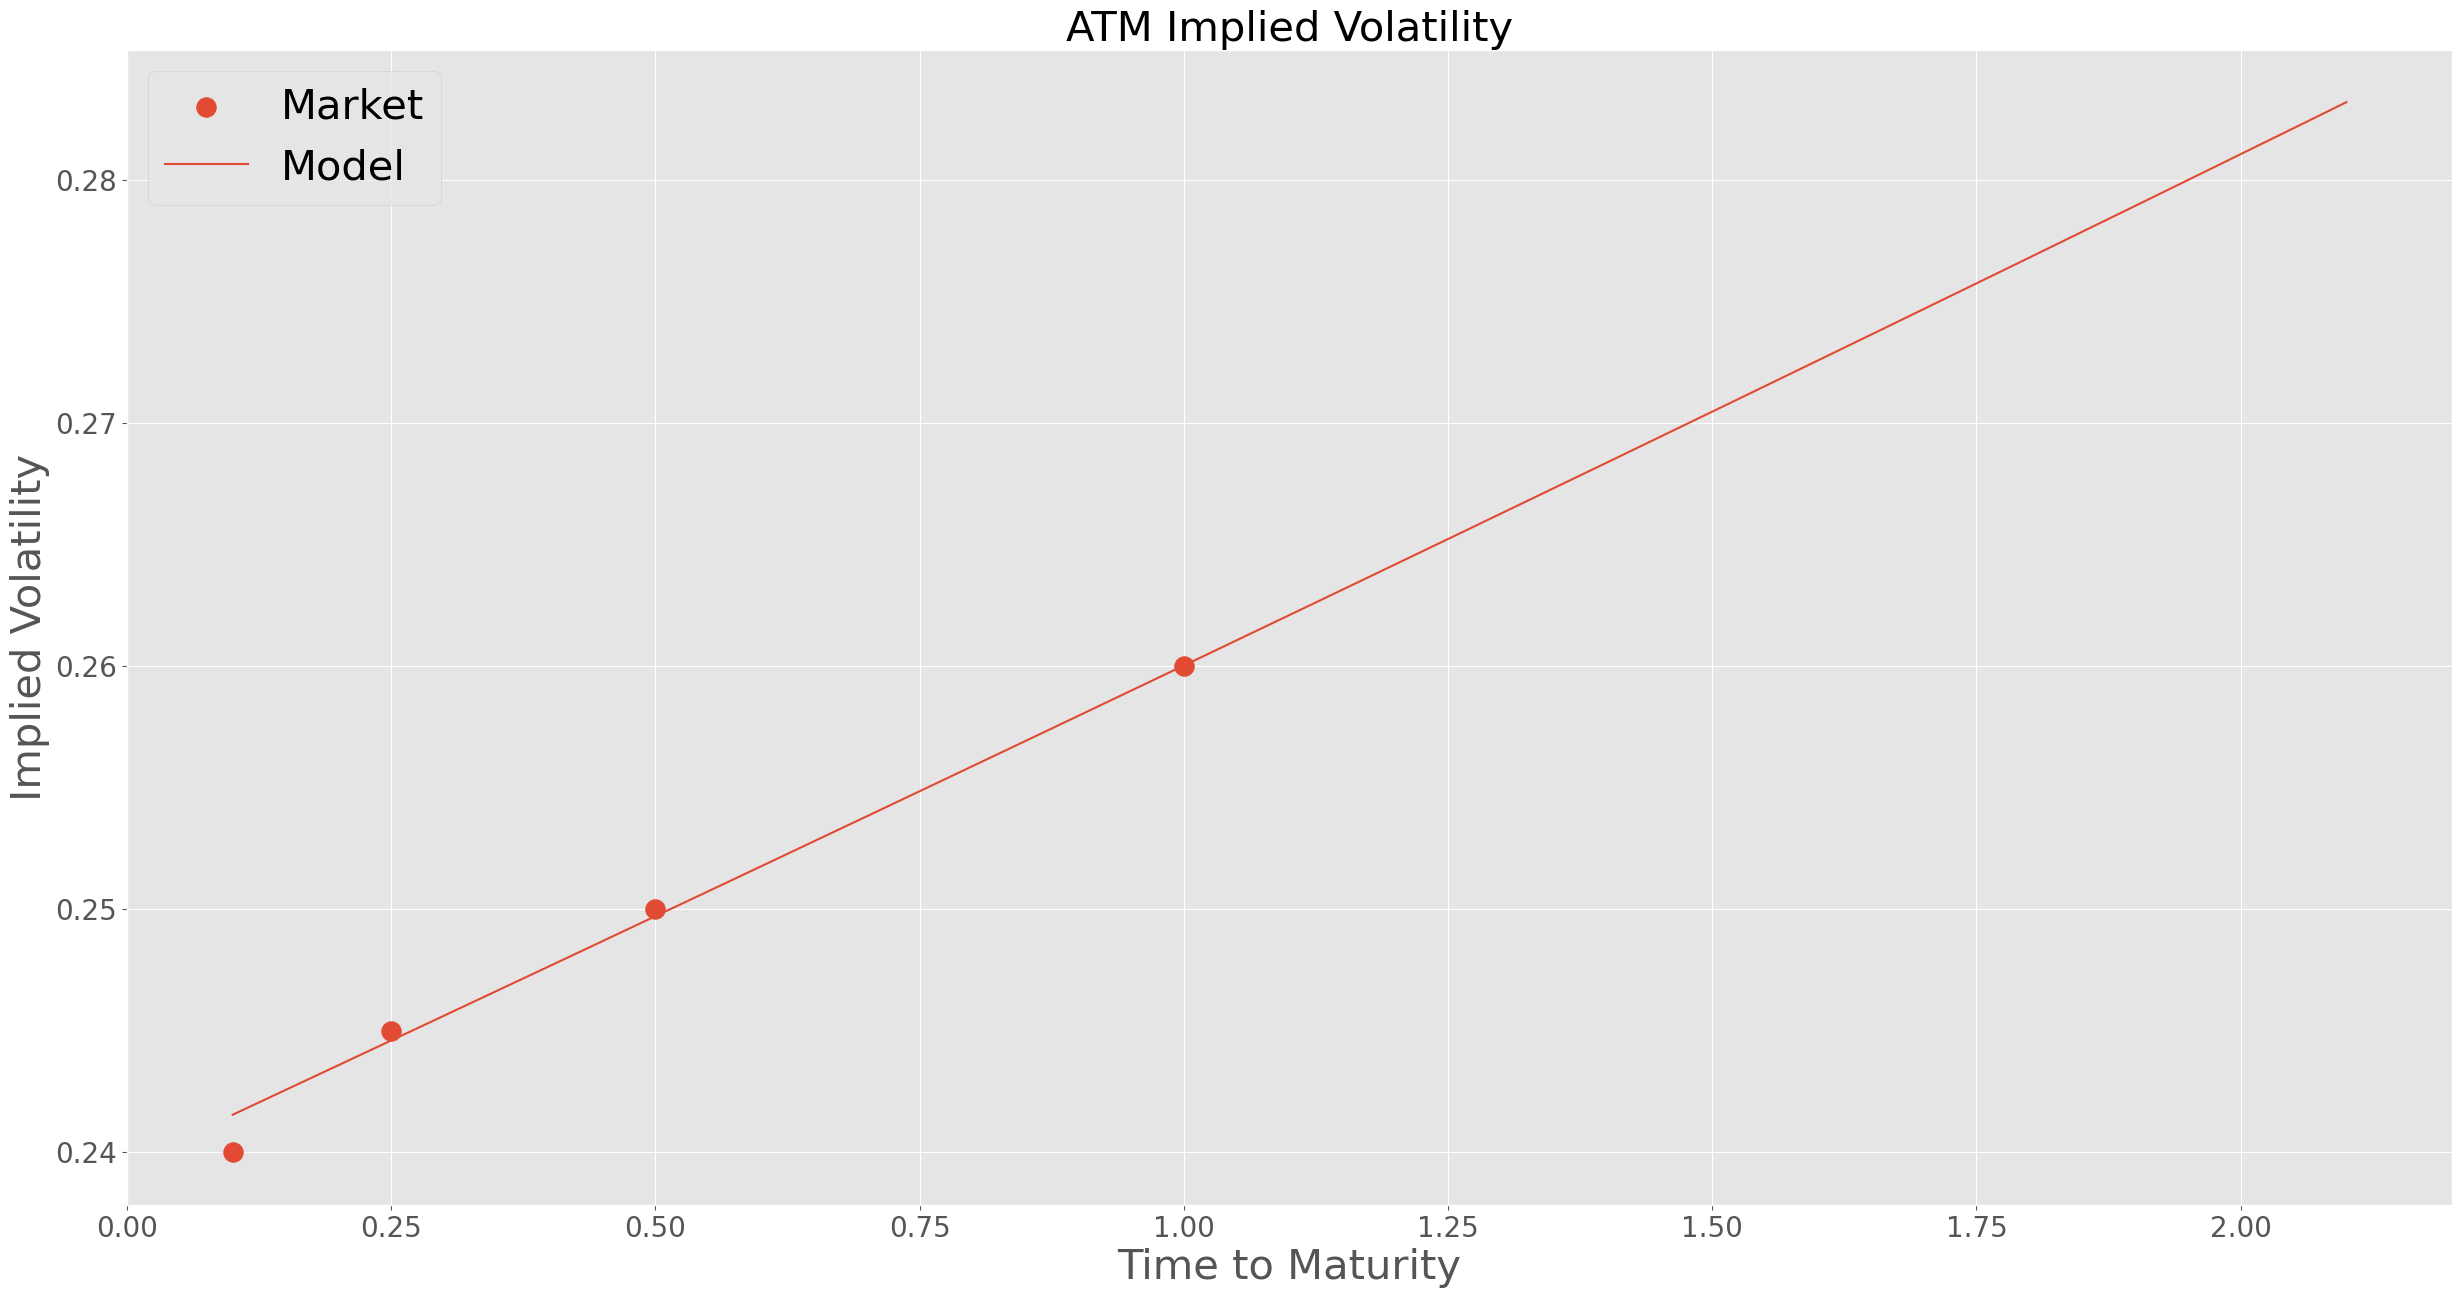

In [208]:
t_ = np.linspace(0.1, 2.1, 200)
nu_0 = 0.2**2
nu_inf = 0.3**2
kappa = 0.5
IV_ATM = [(theta(t, *new_paramsATM)/t)**.5 for t in t_]
fig, axs = plt.subplots(1,figsize = (30, 15))
axs.scatter(T_ATM, Vol_ATM, label="Market", s = 200)
axs.plot(t_, IV_ATM, label = "Model")
axs.set_title('ATM Implied Volatility', fontsize = 30,)
axs.set_xlabel('Time to Maturity', fontsize = 30)
axs.set_ylabel('Implied Volatility', fontsize = 30)
axs.tick_params(axis='x', labelsize = 20)
axs.tick_params(axis='y', labelsize = 20)
axs.legend(fontsize=30)
plt.show();

Calibration other parameters to market prices

In [211]:
#MeanSquared Error between market and model prices
#params = ﴾eta, lambda_, ﴿rho
def MSE_Price_SSVI(params):
    MSE_Price = 0
    for i in range(len(MarketPrice)):
        MSE_Price = MSE_Price + (CallPrice(S0, (TotalVarSSVI(S0, K[i], T[i], *new_paramsATM, *params)/T[i])**.5, K[i], T[i], r) - MarketPrice[i])**2
    return MSE_Price / len(MarketPrice)
    
warnings.filterwarnings('ignore')
params = [1.0, -.2, -.5] #initial params ﴾eta, lambda_, ﴿rho
result = minimize(MSE_Price_SSVI, params, method = 'SLSQP',tol=1e-10 )
new_params = result['x']
print("Parameters [eta, lambda_, rho]: " + str(new_params))

Parameters [eta, lambda_, rho]: [ 0.80860397 -0.70045577 -0.19367313]


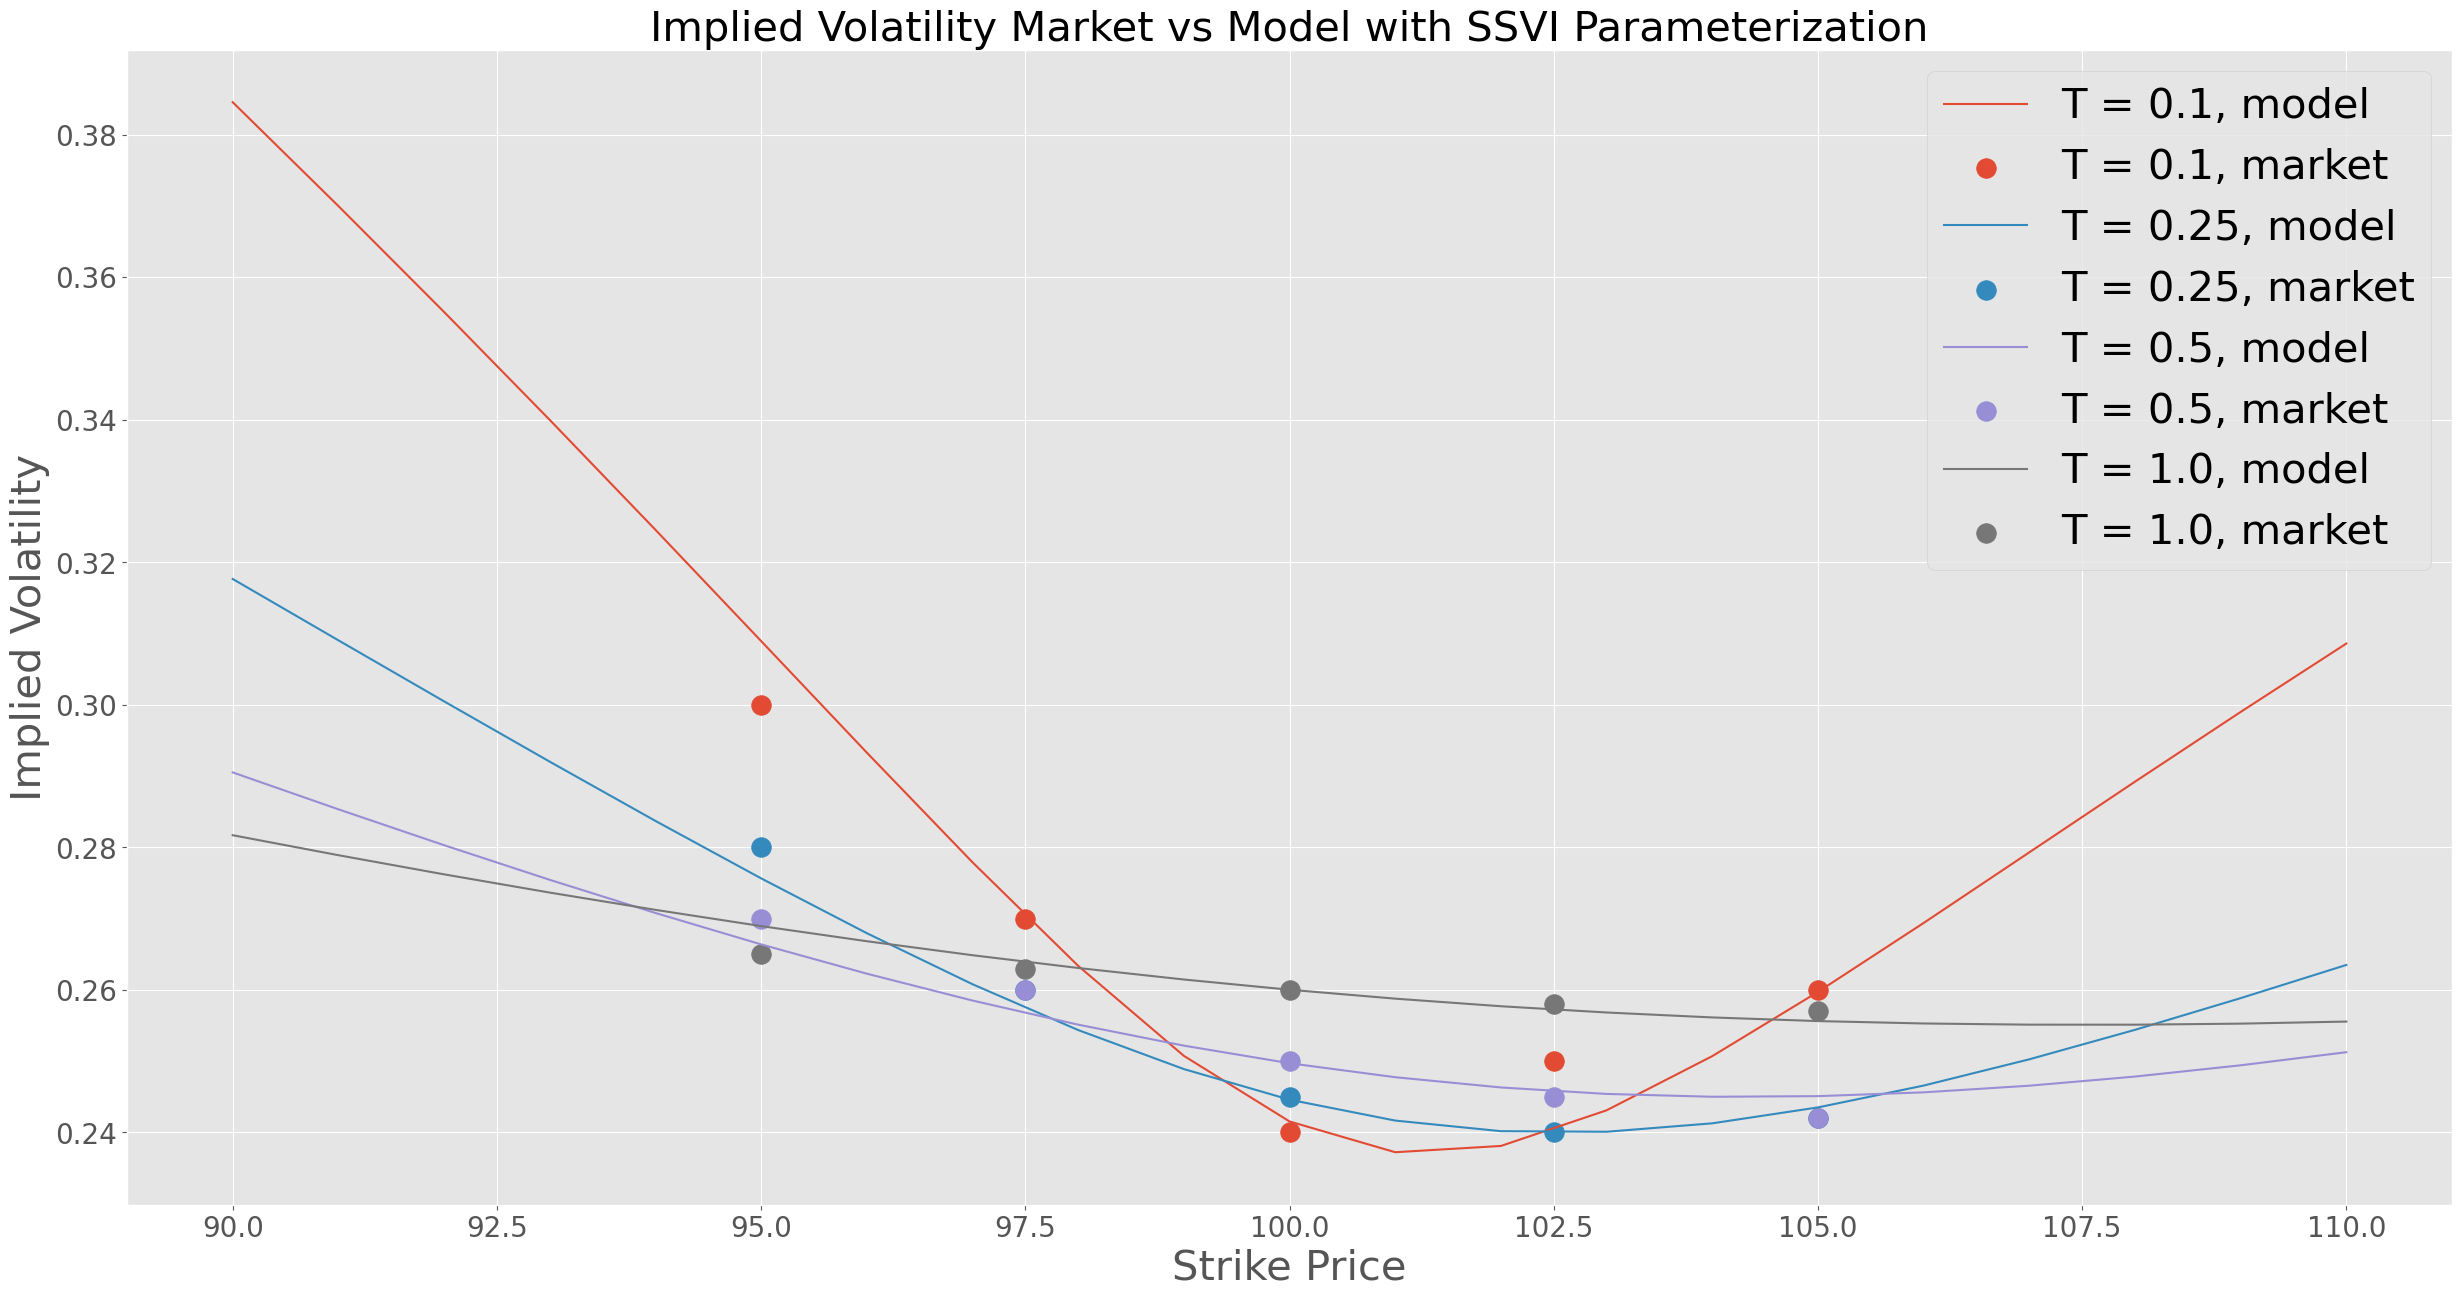

In [213]:
# Parameters
S0 = 100
Strikes = range(90, 111)
t = [0.1, 0.25, 0.5, 1]

IVmodel = [
    [
        (TotalVarSSVI(S0, K, t_, *new_paramsATM, *new_params) / t_)**0.5
        for K in Strikes
    ]
    for t_ in t
]

fig, axs = plt.subplots(1, figsize=(30, 15))

# Plot for T = 0.1
axs.plot(Strikes, IVmodel[0], label="T = 0.1, model")
axs.scatter(
    [K[i] for i in range(len(K)) if T[i] == 0.1],
    [IV[i] for i in range(len(IV)) if T[i] == 0.1],
    label="T = 0.1, market",
    s=200
)

# Plot for T = 0.25
axs.plot(Strikes, IVmodel[1], label="T = 0.25, model")
axs.scatter(
    [K[i] for i in range(len(K)) if T[i] == 0.25],
    [IV[i] for i in range(len(IV)) if T[i] == 0.25],
    label="T = 0.25, market",
    s=200
)

# Plot for T = 0.5
axs.plot(Strikes, IVmodel[2], label="T = 0.5, model")
axs.scatter(
    [K[i] for i in range(len(K)) if T[i] == 0.5],
    [IV[i] for i in range(len(IV)) if T[i] == 0.5],
    label="T = 0.5, market",
    s=200
)

# Plot for T = 1.0
axs.plot(Strikes, IVmodel[3], label="T = 1.0, model")
axs.scatter(
    [K[i] for i in range(len(K)) if T[i] == 1.0],
    [IV[i] for i in range(len(IV)) if T[i] == 1.0],
    label="T = 1.0, market",
    s=200
)

# Add labels, title, and legend
axs.set_title(
    'Implied Volatility Market vs Model with SSVI Parameterization',
    fontsize=30
)
axs.set_xlabel('Strike Price', fontsize=30)
axs.set_ylabel('Implied Volatility', fontsize=30)
axs.tick_params(axis='x', labelsize=20)
axs.tick_params(axis='y', labelsize=20)
axs.legend(fontsize=30)

# Show the plot
plt.show()


## Is SSVI Arbitrage-Free ?

Gatheral and Jacquier have showed that The SSVI surface is :

### Free of butterfly arbitrage if:
1. $\theta \cdot \phi(\theta) \cdot (1 + |\rho|) < 4$
2. $\theta \cdot \phi(\theta)^2 \cdot (1 + |\rho|) \leq 4$

for all $\theta > 0$.

---

### Free of calendar spread arbitrage if and only if:
1. $\partial_t \theta_t \geq 0$ for all $t \geq 0$
2. $0 \leq \partial_\theta (\theta \cdot \phi(\theta))$

   $\partial_\theta (\theta \cdot \phi(\theta)) \leq \frac{1}{\rho^2} \cdot \left(1 + \sqrt{1 - \rho^2} \right) \cdot \phi(\theta)$ 

   for all $\theta > 0$.
